# Multiple Kernel Learning
Research - Caio<>Nicholas

## 0. Import

In [1]:
# using Pkg
# Pkg.add(["CSV", "DataFrames", "JuMP", "Gurobi", "LinearAlgebra", "Statistics"])

## 1. Simple SVM - Iris Dataset 2D

### 1.1 Preprocess Iris Data

In [14]:
using CSV, DataFrames, LinearAlgebra, Statistics, Random, JuMP, Gurobi
using Plots

# Load dataset (Iris dataset)
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
iris = CSV.read(download(url), DataFrame, header=false)

# Rename columns
rename!(iris, [:sepal_length, :sepal_width, :petal_length, :petal_width, :species])

# Convert to binary classification (Iris-setosa vs. not Iris-setosa)
iris.binary_class = iris.species .== "Iris-setosa"  # Setosa = 1, others = 0
iris = filter(row -> row.binary_class == 1 || row.binary_class == 0, iris)

# Encode labels as +1 and -1
labels = [b ? 1 : -1 for b in iris.binary_class]

# Select only the first two features (Sepal Length and Sepal Width)
features = Matrix(iris[:, [:sepal_length, :sepal_width]])

# Normalize features
features = (features .- mean(features, dims=1)) ./ std(features, dims=1)

# Set random seed for reproducibility
Random.seed!(123)

# Shuffle indices and split the dataset
n = size(features, 1)  # Number of samples
indices = shuffle(1:n)

# Define the split ratio
train_ratio = 0.8
train_size = Int(floor(train_ratio * n))

# Split into training and testing sets
train_indices = indices[1:train_size]
test_indices = indices[train_size+1:end]

X_train = features[train_indices, :]
y_train = labels[train_indices]
X_test = features[test_indices, :]
y_test = labels[test_indices]

30-element Vector{Int64}:
 -1
 -1
 -1
  1
 -1
 -1
 -1
  1
 -1
 -1
  1
 -1
  1
  ⋮
 -1
 -1
  1
 -1
 -1
 -1
 -1
  1
 -1
 -1
 -1
 -1

In [15]:

# Function to create meshgrid
function meshgrid(x, y)
    X = repeat(x', length(y), 1)
    Y = repeat(y, 1, length(x))
    return X, Y
end

# Define the kernel functions
function kernel(X, kernel_type; degree=3, gamma=1.0)
    n = size(X, 1)
    K = zeros(n, n)

    if kernel_type == "linear"
        K = X * X'  # Linear kernel
    elseif kernel_type == "polynomial"
        K = (X * X' .+ 1) .^ degree  # Polynomial kernel
    elseif kernel_type == "rbf"
        for i in 1:n
            for j in 1:n
                K[i, j] = exp(-gamma * norm(X[i, :] - X[j, :])^2)  # RBF kernel
            end
        end
    else
        throw(ArgumentError("Unsupported kernel type: $kernel_type"))
    end

    return K
end

# Train SVM model with kernel options
function train_svm(X, y, C, kernel_type; degree=3, gamma=1.0)
    n = size(X, 1)
    K = kernel(X, kernel_type; degree=degree, gamma=gamma)  # Generate kernel matrix

    # Start the JuMP model
    model = Model(Gurobi.Optimizer)
    set_optimizer_attribute(model, "OutputFlag", 0)  # Suppress Gurobi output

    # Define the dual variables α
    @variable(model, 0 <= α[i=1:n] <= C)

    # Define the objective function
    @objective(model, Max, sum(α) - 0.5 * sum((y[i] * y[j] * α[i] * α[j] * K[i, j])
                                              for i in 1:n, j in 1:n))

    # Add the constraint: ∑ α_i * y_i = 0
    @constraint(model, sum(α[i] * y[i] for i in 1:n) == 0)

    # Solve the model
    optimize!(model)

    # Retrieve the α values
    α_values = value.(α)

    return α_values, K  # Return both α and K
end


train_svm (generic function with 1 method)

In [16]:
# Function to compute the bias term b
function compute_bias(α, y, K, C; tolerance=1e-5)
    n = length(α)
    b_values = []

    for i in 1:n
        if α[i] > tolerance && α[i] < C - tolerance  # Support vectors with 0 < α_i < C
            s = sum(α[j] * y[j] * K[j, i] for j in 1:n)
            push!(b_values, y[i] - s)
        end
    end

    # Take the average of all computed b values
    b = mean(b_values)
    return b
end

# Function to make predictions using the trained SVM model
function predict_svm(α, y_train, X_train, X_new, b, kernel_type;
                     degree=3, gamma=1.0, tolerance=1e-5)
    # Identify support vectors
    support_indices = findall(α .> tolerance)
    α_support = α[support_indices]
    y_support = y_train[support_indices]
    X_support = X_train[support_indices, :]

    n_new = size(X_new, 1)
    predictions = zeros(n_new)

    # Compute the kernel between support vectors and new data
    if kernel_type == "linear"
        K_new = X_support * X_new'
    elseif kernel_type == "polynomial"
        K_new = (X_support * X_new' .+ 1) .^ degree
    elseif kernel_type == "rbf"
        K_new = zeros(length(support_indices), n_new)
        for i in 1:length(support_indices)
            for j in 1:n_new
                K_new[i, j] = exp(-gamma * norm(X_support[i, :] - X_new[j, :])^2)
            end
        end
    else
        throw(ArgumentError("Unsupported kernel type: $kernel_type"))
    end

    # Make predictions
    for i in 1:n_new
        s = sum(α_support .* y_support .* K_new[:, i])
        predictions[i] = s + b
    end

    # Return the sign of the predictions (+1 or -1)
    return sign.(predictions)
end

predict_svm (generic function with 1 method)

In [17]:
# Function to plot the decision boundary
function plot_decision_boundary(α, b, X_train, y_train, kernel_type;
                                degree=3, gamma=1.0, resolution=100, tolerance=1e-5)
    # Determine the range of the grid
    x_min = minimum(X_train[:, 1]) - 1
    x_max = maximum(X_train[:, 1]) + 1
    y_min = minimum(X_train[:, 2]) - 1
    y_max = maximum(X_train[:, 2]) + 1

    # Create a grid of points
    x_range = range(x_min, x_max, length=resolution)
    y_range = range(y_min, y_max, length=resolution)
    xx, yy = meshgrid(x_range, y_range)
    grid_points = hcat(vec(xx), vec(yy))

    # Predict over the grid
    Z = predict_svm(α, y_train, X_train, grid_points, b, kernel_type;
                    degree=degree, gamma=gamma, tolerance=tolerance)
    Z = reshape(Z, size(xx))

    # Define colors for each class
    unique_labels = sort(unique(y_train))  # Ensure consistent ordering
    label_colors = Dict(unique_labels[1] => :blue, unique_labels[2] => :green)

    # Initialize the plot
    plt = plot(title="SVM Decision Boundary ($kernel_type kernel)",
               xlabel="Feature 1", ylabel="Feature 2",
               legend=:topright)

    # Plot the data points for each class
    for lbl in unique_labels
        indices = findall(y_train .== lbl)
        scatter!(plt, X_train[indices, 1], X_train[indices, 2],
                 color=label_colors[lbl], marker=:circle,
                 label="Class $lbl")
    end

    # Plot the decision boundary
    contour!(plt, x_range, y_range, Z; levels=[0.0], linewidth=2, color=:black, label="Decision Boundary")

    # Highlight support vectors
    support_indices = findall(α .> tolerance)
    if !isempty(support_indices)
        sv_x = X_train[support_indices, 1]
        sv_y = X_train[support_indices, 2]
        sv_labels = y_train[support_indices]
        sv_colors = [label_colors[lbl] for lbl in sv_labels]

        # Plot all support vectors together
        scatter!(plt, sv_x, sv_y,
                 color=sv_colors,
                 marker=:circle, markersize=10,
                 markerstrokecolor=:black, markerstrokewidth=2,
                 label="Support Vectors")
    end

    display(plt)
end

plot_decision_boundary (generic function with 1 method)


Kernel Type: linear
Set parameter Username
Academic license - for non-commercial use only - expires 2025-08-19
Training Accuracy: 99.16666666666667 %
Testing Accuracy: 100.0 %


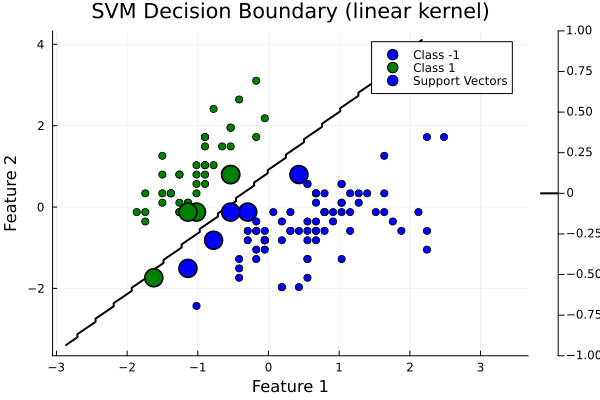


Kernel Type: polynomial
Set parameter Username
Academic license - for non-commercial use only - expires 2025-08-19
Training Accuracy: 100.0 %
Testing Accuracy: 100.0 %


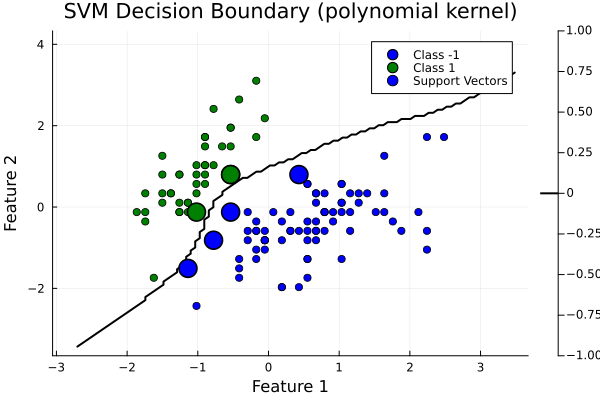


Kernel Type: rbf
Set parameter Username
Academic license - for non-commercial use only - expires 2025-08-19
Training Accuracy: 100.0 %
Testing Accuracy: 100.0 %


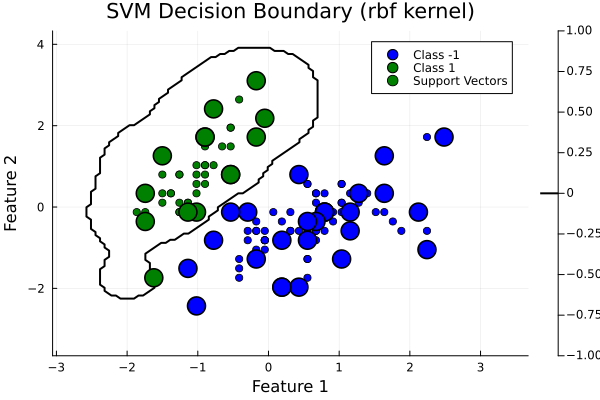

In [18]:
# Training parameters
C = 1.0
kernel_types = ["linear", "polynomial", "rbf"]  # List of kernels to test

for kernel_type in kernel_types
    println("\nKernel Type: $kernel_type")

    if kernel_type == "polynomial"
        degree = 5  # You can vary this
        γ = nothing  # Not used for polynomial
    elseif kernel_type == "rbf"
        γ = 2.0     # You can vary this
        degree = nothing  # Not used for RBF
    else
        degree = nothing
        γ = nothing
    end

    # Train the SVM model
    α, K_train = train_svm(X_train, y_train, C, kernel_type; degree=degree, gamma=γ)

    # Compute the bias term b
    b = compute_bias(α, y_train, K_train, C)

    # Make predictions on the training set
    y_pred_train = predict_svm(α, y_train, X_train, X_train, b, kernel_type;
                               degree=degree, gamma=γ)

    # Calculate training accuracy
    train_accuracy = mean(y_pred_train .== y_train) * 100
    println("Training Accuracy: $train_accuracy %")

    # Make predictions on the testing set
    y_pred_test = predict_svm(α, y_train, X_train, X_test, b, kernel_type;
                              degree=degree, gamma=γ)

    # Calculate testing accuracy
    test_accuracy = mean(y_pred_test .== y_test) * 100
    println("Testing Accuracy: $test_accuracy %")

    # Plot the decision boundary
    plot_decision_boundary(α, b, X_train, y_train, kernel_type; degree=degree, gamma=γ)
end
